In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
from deeplifting.models import DeepliftingSkipMLP
from sklearn.datasets import load_iris
import pandas as pd
import torch
import numpy as np

# import pygranso functions
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

In [4]:
device = torch.device('cpu')

# Load the dataset
iris = load_iris()

# The data and target labels
data = iris.data
labels = iris.target

# If you want the feature names and target names:
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(data=iris.data, columns=['f1', 'f2', 'f3', 'f4'])
df['f5'] = 1.0
df['target'] = iris.target

df = df.sample(frac=1.0).reset_index(drop=True)

# Dimensions
output_size = len(feature_names) + 1

# Inputs
inputs_X = df[['f1', 'f2', 'f3', 'f4', 'f5']].values
inputs_X = torch.from_numpy(inputs_X).to(device=device, dtype=torch.double).T

# Just two classes for now
labels = df['target'].values

y = np.zeros(len(labels))
y[labels != 1] = 1
y[labels == 1] = -1
y = torch.from_numpy(y).to(device=device, dtype=torch.double)

In [5]:
inputs_X.shape, labels.shape

(torch.Size([5, 150]), (150,))

In [6]:
# Set up the learning function
def deeplifting_svm(model, inputs_X, labels):
    outputs = model(None)
    weight_vec = outputs.mean(axis=0)

    # Compute SVM objective
    denominator = torch.linalg.norm(weight_vec, ord=2)
    prod = torch.matmul(weight_vec.T, inputs_X)
    numerator = labels * prod
    obj = numerator / denominator

    # Orig obj
    f = torch.amax(-1 * obj)

    ce = None
    ci = None
    return f, ci, ce


# Set up a model
# Deeplifting model with skip connections
model = DeepliftingSkipMLP(
    input_size=1,
    hidden_sizes=(64,) * 2,
    output_size=output_size,
    bounds=None,
    skip_every_n=1,
    activation='relu',
    output_activation='sine',
    agg_function='sum',
    include_bn=True,
    seed=1,
)

In [7]:
# Deeplifting time!
device = torch.device('cpu')
model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())

opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

# PyGranso options
# Increase max number of iterations and let convege to stationarity
# Do we see local minima in the PyGranso version
# Dual Annealing, SCIP and Deeplifting, PyGranso (showing there are local minima)
opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

# Combined function
comb_fn = lambda model: deeplifting_svm(model, inputs_X, y)  # noqa

# Run the main algorithm
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_45894/3425520376.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  prod = torch.matmul(weight_vec.T, inputs_X)




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

In [8]:
# Get the best weights and let's check training sample fit
best_weights = model(None)
best_weights = best_weights.mean(axis=0)
best_weights = best_weights.detach().cpu().numpy()
best_weights

array([-0.19385719,  0.00757785,  0.08641009, -0.02262044,  0.8320364 ])

In [9]:
inputs_X = inputs_X.cpu().numpy()
y = y.cpu().numpy()

In [10]:
raw_predictions = np.dot(best_weights, inputs_X)
predictions = np.sign(raw_predictions)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y, predictions)

0.47333333333333333

In [13]:
y, predictions

(array([ 1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,
         1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,
        -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
         1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,
         1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,
         1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
         1., -1.,  1., -1.,  1.,  1.,  1.]),
 array([ 1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
         1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
      

In [14]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

/Users/ryandevera/.virtualenvs/deeplifing/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


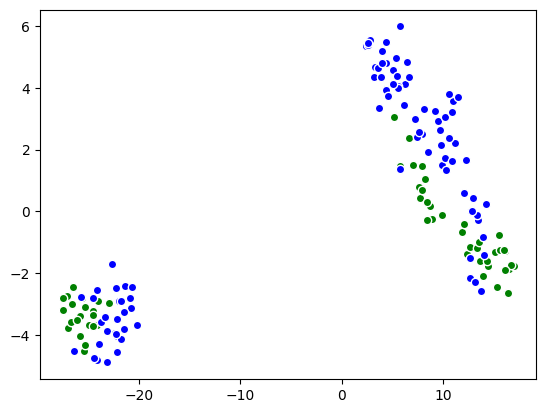

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['setosa', 'other']
# Apply t-SNE to the data
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(inputs_X.T[:, :-1])

# Create a scatter plot
# Create a scatter plot using matplotlib
colors = ['red', 'blue', 'green']  # Define a color for each class
for i in [-1, 1]:
    plt.scatter(
        X_tsne[predictions == i, 0],
        X_tsne[predictions == i, 1],
        c=colors[i],
        label=target_names[i],
        edgecolors='w',
    )

In [16]:
# from sklearn import datasets
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Load the iris dataset
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# labels = np.zeros(len(y))
# labels[y != 0] = -1
# labels[y == 0] = 1

# # Initialize the Support Vector Machine Classifier
# clf = SVC(kernel='linear')

# # Fit the model to the training data
# clf.fit(X, labels)

# # Predict the labels of the test set
# y_pred = clf.predict(X)

# # Calculate the accuracy of the model
# accuracy_score(labels, y_pred)

In [17]:
# labels

In [18]:
# y_pred

In [19]:
# Set up the learning function
def svm(X_struct, inputs_X, labels):
    weight_vec = X_struct.w

    # Compute SVM objective
    denominator = torch.linalg.norm(weight_vec, ord=2)
    prod = torch.matmul(weight_vec.T, inputs_X)
    numerator = labels * prod
    obj = numerator / denominator

    # Orig obj
    f = torch.amax(-1 * obj)

    ce = None
    ci = None
    return f, ci, ce

In [20]:
# Load the dataset
iris = load_iris()

# The data and target labels
data = iris.data
labels = iris.target

# If you want the feature names and target names:
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(data=iris.data, columns=['f1', 'f2', 'f3', 'f4'])
df['f5'] = 1.0
df['target'] = iris.target

df = df.sample(frac=1.0).reset_index(drop=True)

# Dimensions
output_size = len(feature_names) + 1

# Inputs
inputs_X = df[['f1', 'f2', 'f3', 'f4', 'f5']].values
inputs_X = torch.from_numpy(inputs_X).to(device=device, dtype=torch.double).T

# Just two classes for now
labels = df['target'].values

y = np.zeros(len(labels))
y[labels != 1] = 1
y[labels == 1] = -1
y = torch.from_numpy(y).to(device=device, dtype=torch.double)

# Deeplifting time!
device = torch.device('cpu')

w0 = torch.randn(
    (5, 1),
).to(device, dtype=torch.double)
var_in = {"w": list(w0.shape)}

comb_fn = lambda X_struct: svm(
    X_struct,
    inputs_X,
    y,
)

opts = pygransoStruct()

# PyGranso options
# Increase max number of iterations and let convege to stationarity
# Do we see local minima in the PyGranso version
# Dual Annealing, SCIP and Deeplifting, PyGranso (showing there are local minima)
opts.x0 = torch.reshape(w0, (-1, 1))
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

# Run the main algorithm
soln = pygranso(var_spec=var_in, combined_fn=comb_fn, user_opts=opts)



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

In [21]:
best_weights = soln.best.x

In [22]:
raw_predictions = np.dot(best_weights.T, inputs_X)
predictions = np.sign(raw_predictions)

In [23]:
accuracy_score(y.numpy().flatten(), predictions.flatten())

0.47333333333333333